In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../training_utils/')
from data_utils import get_folders, get_class_weights
from train_utils import predict
from diagnostic_tools import top_k_accuracy, per_class_accuracy,\
    count_params, entropy, model_calibration, show_errors, most_confused_classes,\
    most_inaccurate_k_classes

torch.cuda.is_available()

True

# Load the model

In [3]:
from get_densenet121 import get_model

In [4]:
_, val_folder = get_folders()

In [5]:
# w[j]: 1/number_of_samples_in_class_j
# decode: folder name to class name (in human readable format)
w, decode = get_class_weights(val_folder.class_to_idx)

In [6]:
model, _, _ = get_model(class_weights=torch.FloatTensor(w/w.sum()))

# load pretrained quantized model
model.load_state_dict(torch.load('model121_ternary_quantization.pytorch_state'))

In [7]:
# number of params in the model
count_params(model)

7216256

# Show some quantized kernel tensors (there are 119 such kernels overall)

In [8]:
# all quantized kernels
all_kernels = [
    (n, p.data) for n, p in model.named_parameters() 
    if ('denseblock' in n or 'transition' in n) and 'conv' in n
]

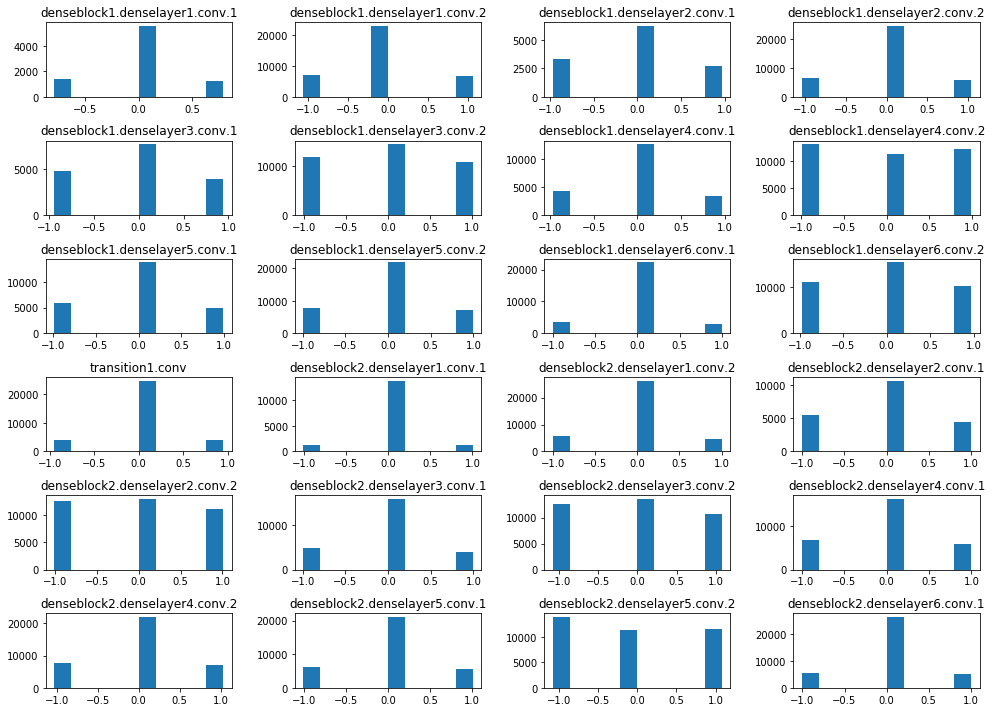

In [9]:
# show distribution of weights in kernels that are in the beginning of the network 
_, axes = plt.subplots(nrows=6, ncols=4, figsize=(14, 10))
axes = axes.flatten()
for i, (name, kernel) in enumerate(all_kernels[:24]):
    axes[i].hist(kernel.cpu().numpy().reshape(-1));
    axes[i].set_title(name[9:-7]);

plt.tight_layout()

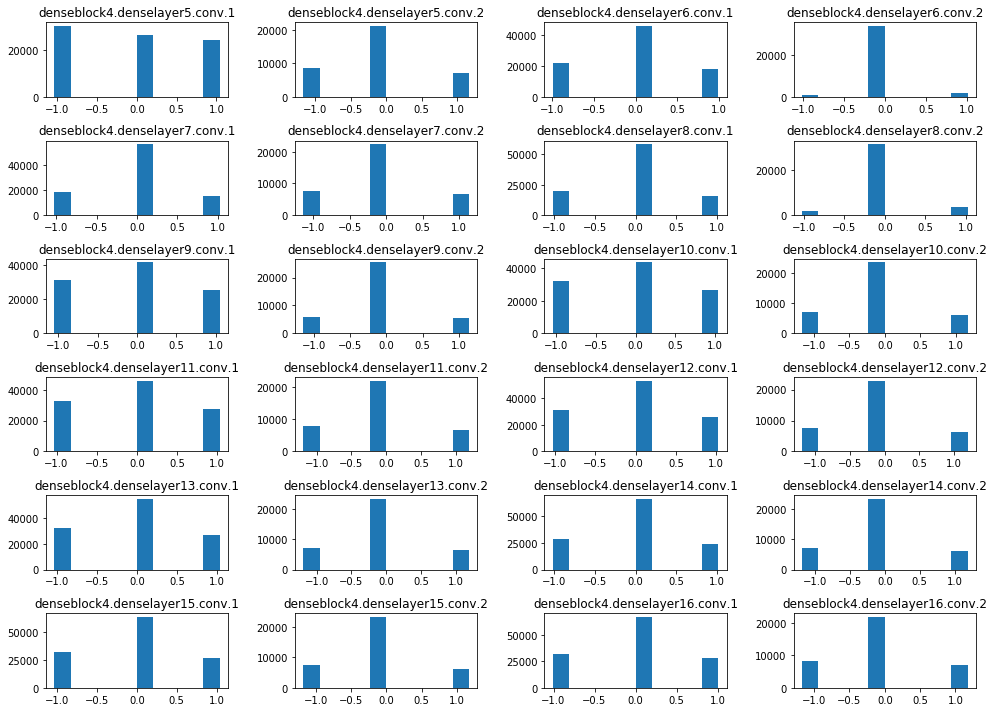

In [39]:
# kernels in the end of the network 
_, axes = plt.subplots(nrows=6, ncols=4, figsize=(14, 10))
axes = axes.flatten()
for i, (name, kernel) in enumerate(all_kernels[-24:]):
    axes[i].hist(kernel.cpu().numpy().reshape(-1));
    axes[i].set_title(name[9:-7]);

plt.tight_layout()

# sparcity distribution

In [36]:
sparcity = []
for n, p in all_kernels:
    sparcity.append(p.eq(0.0).float().mean())

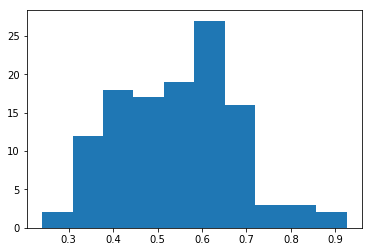

In [37]:
plt.hist(sparcity);

In [48]:
np.mean(sparcity)

0.54723190985807857

# scaling factors

In [42]:
upper_scaling_factor = []
lower_scaling_factor = []
for n, p in all_kernels:
    upper_scaling_factor.append(p.max())
    lower_scaling_factor.append(p.min())

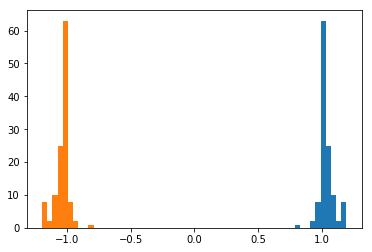

In [44]:
plt.hist(upper_scaling_factor);
plt.hist(lower_scaling_factor);

# Error analysis

### get human readable class names

In [11]:
# index to class name
decode = {val_folder.class_to_idx[k]: decode[int(k)] for k in val_folder.class_to_idx}

### get all predictions and all misclassified images 

In [12]:
val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=64, shuffle=False
)

In [13]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 80/80 [00:31<00:00,  2.46it/s]


### number of misclassified images (there are overall 5120 images in the val dataset)

In [14]:
n_errors = len(erroneous_targets)
n_errors

1478

### logloss and accuracies

In [15]:
log_loss(val_true_targets, val_predictions)

1.1849510462715065

In [16]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.71132812499999998

In [17]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.80683593750000004, 0.84589843750000004, 0.87031250000000004, 0.88945312499999996, 0.93203124999999998]


### entropy of predictions

In [18]:
hits = val_predictions.argmax(1) == val_true_targets

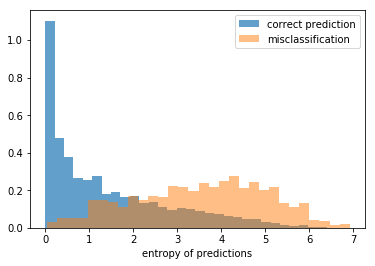

In [19]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

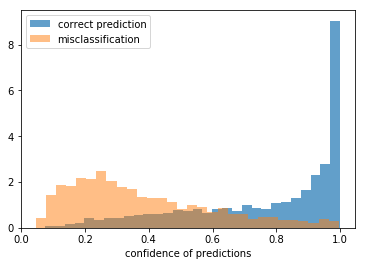

In [20]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

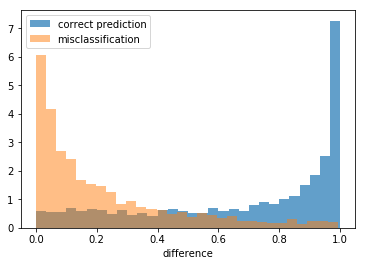

In [21]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

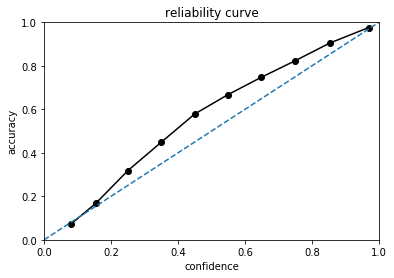

In [22]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

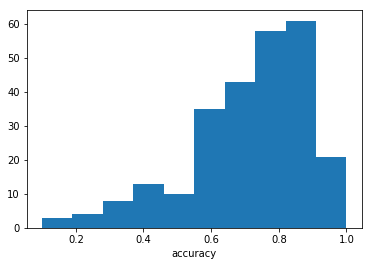

In [23]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [24]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

drinking-straw 0.1
playing-card 0.1
rifle 0.15
skateboard 0.2
coffin 0.2
mountain-bike 0.25
knife 0.25
sneaker 0.3
spoon 0.3
welding-mask 0.3
snake 0.3
flashlight 0.35
sword 0.35
frog 0.35
mailbox 0.35


### class accuracy vs. number of samples in the class

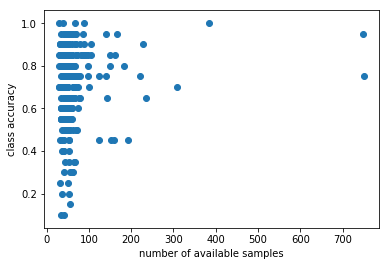

In [25]:
plt.scatter((1.0/w), per_class_acc);
plt.ylabel('class accuracy');
plt.xlabel('number of available samples');

### most confused pairs of classes

In [26]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=4
)
confused_pairs

[('ak47', 'rifle'),
 ('beer-mug', 'coffee-mug'),
 ('helicopter', 'fighter-jet'),
 ('hot-dog', 'people'),
 ('house-fly', 'cockroach'),
 ('ice-cream-cone', 'drinking-straw'),
 ('iris', 'cactus'),
 ('kangaroo', 'llama'),
 ('kayak', 'canoe'),
 ('killer-whale', 'dolphin'),
 ('knife', 'sword'),
 ('mandolin', 'electric-guitar'),
 ('microscope', 'theodolite'),
 ('minaret', 'smokestack'),
 ('mountain-bike', 'touring-bike'),
 ('pyramid', 'teepee'),
 ('radio-telescope', 'windmill'),
 ('scorpion', 'crab'),
 ('bowling-pin', 'wine-bottle'),
 ('screwdriver', 'syringe'),
 ('screwdriver', 'flashlight'),
 ('skyscraper', 'smokestack'),
 ('sneaker', 'tennis-shoes'),
 ('spoon', 'tweezer'),
 ('swan', 'goose'),
 ('breadmaker', 'washing-machine'),
 ('touring-bike', 'tricycle'),
 ('windmill', 'eiffel-tower'),
 ('chimp', 'gorilla')]

### show some low entropy errors

In [27]:
erroneous_entropy = entropy(erroneous_predictions)
mean_entropy = erroneous_entropy.mean()
low_entropy = mean_entropy < erroneous_entropy
mean_entropy

3.5139759360110761

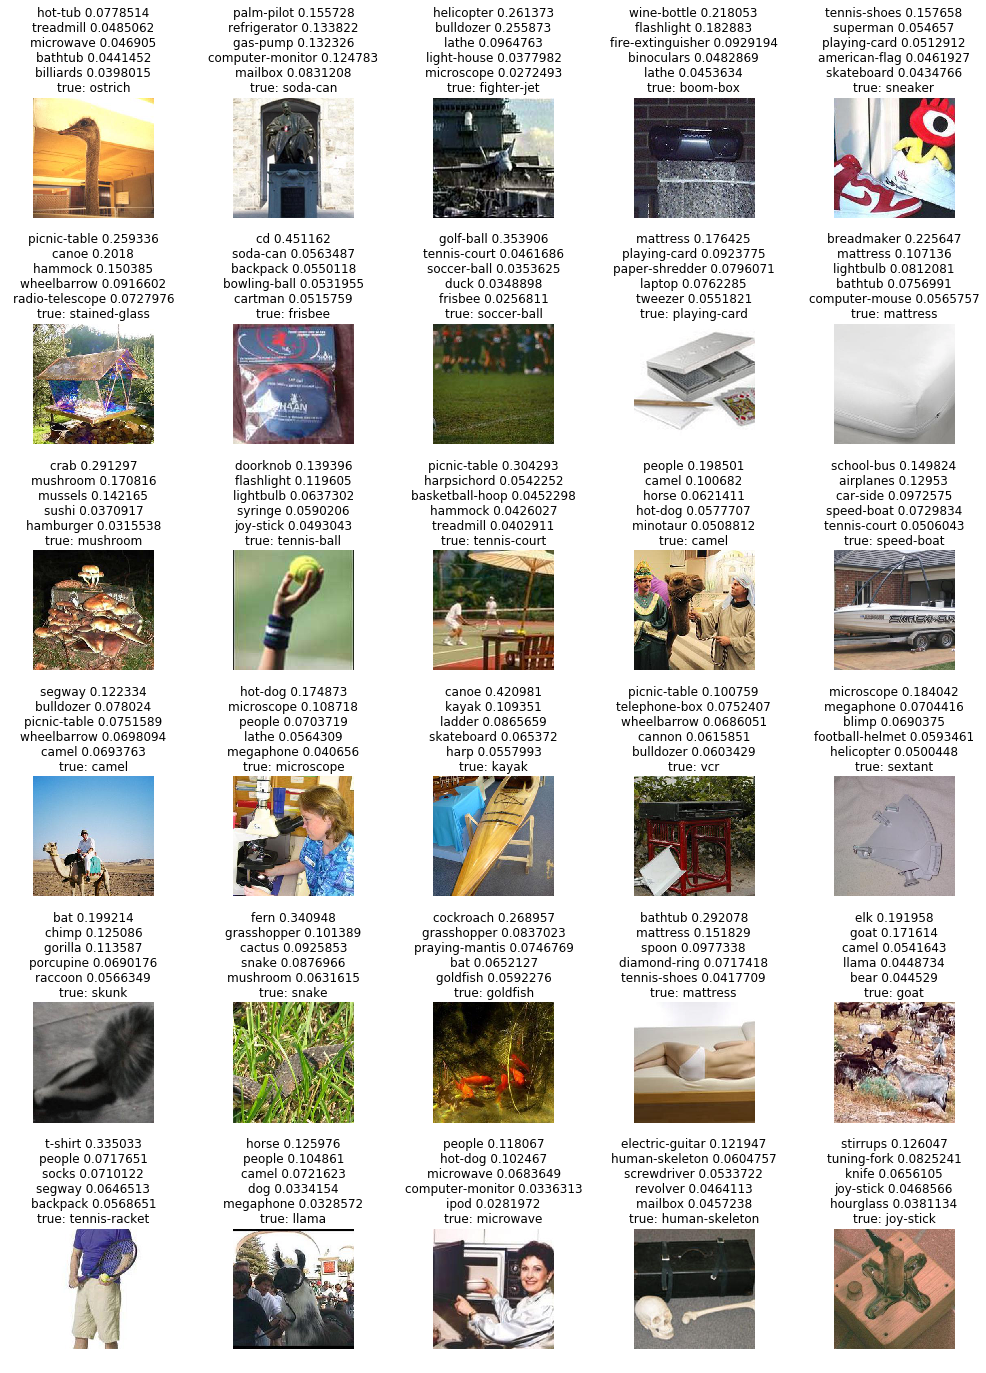

In [28]:
show_errors(
    erroneous_samples[low_entropy], 
    erroneous_predictions[low_entropy], 
    erroneous_targets[low_entropy], 
    decode
)

### show some high entropy errors

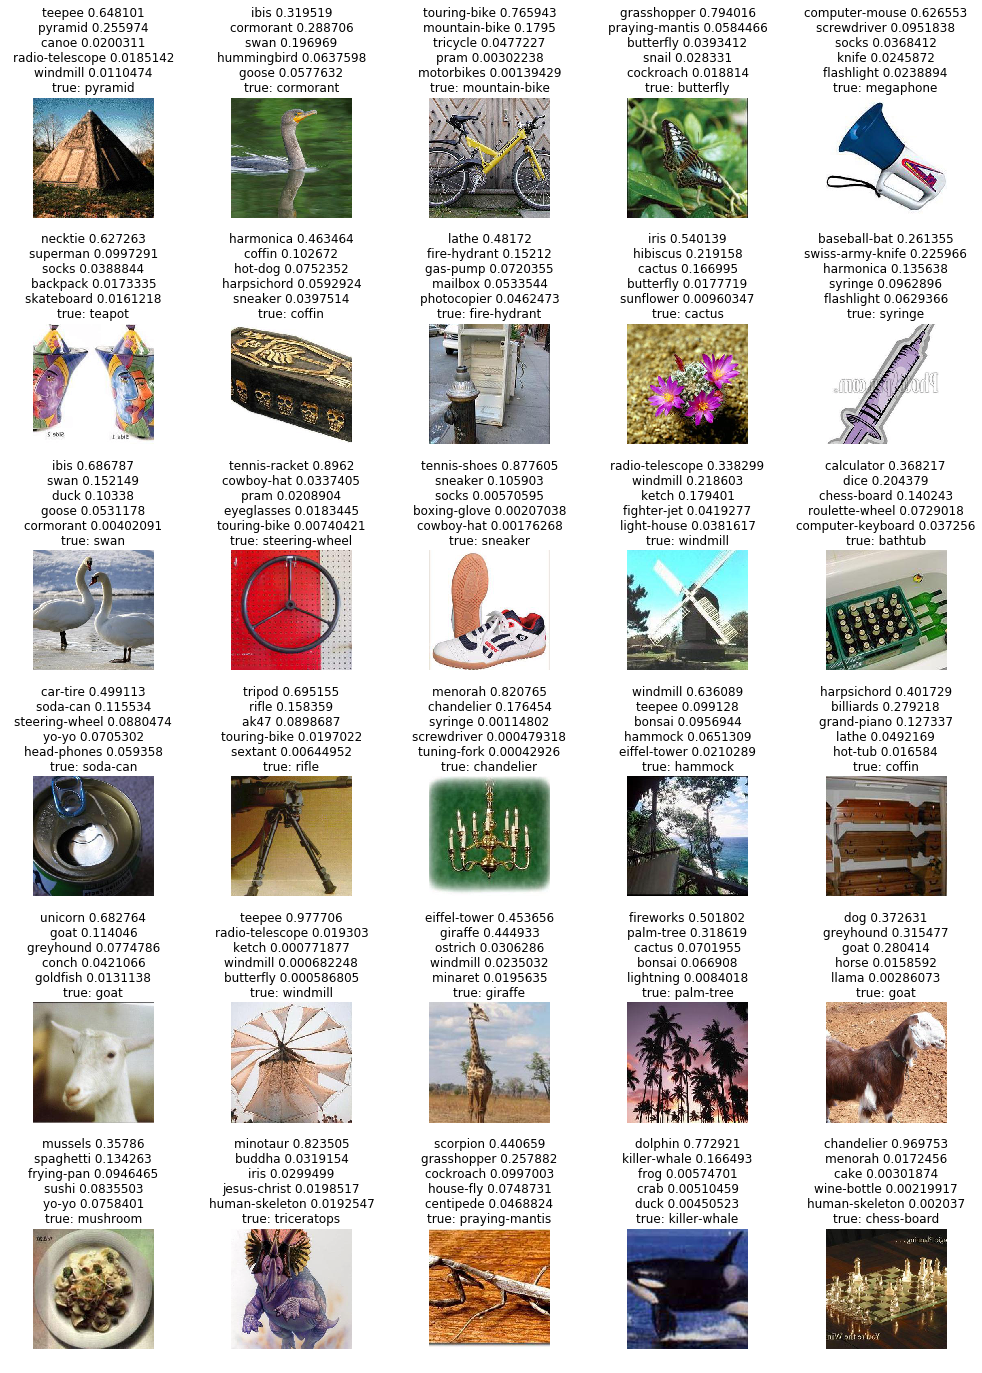

In [29]:
show_errors(
    erroneous_samples[~low_entropy], 
    erroneous_predictions[~low_entropy], 
    erroneous_targets[~low_entropy], 
    decode
)